In [1]:
import os
import pandas as pd
import numpy as np
import gc
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
from scipy import stats
import random
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import *
import warnings

import pickle
import lightgbm as lgb
from sklearn.model_selection import train_test_split

In [2]:
%%time
n_features = 300
features = [f'f_{i}' for i in range(n_features)]
train = pd.read_pickle('../input/ubiquant-market-prediction-half-precision-pickle/train.pkl')
train.head()

CPU times: total: 547 ms
Wall time: 545 ms


,investment_id,time_id,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,...,f_291,f_292,f_293,f_294,f_295,f_296,f_297,f_298,f_299,target
0,1,0,0.932617,0.113708,-0.402100,0.378418,-0.203979,-0.413574,0.965820,1.230469,...,-1.095703,0.200073,0.819336,0.941406,-0.086792,-1.086914,-1.044922,-0.287598,0.321533,-0.300781
1,2,0,0.811035,-0.514160,0.742188,-0.616699,-0.194214,1.771484,1.427734,1.133789,...,0.912598,-0.734375,0.819336,0.941406,-0.387695,-1.086914,-0.929688,-0.974121,-0.343506,-0.231079
2,6,0,0.394043,0.615723,0.567871,-0.607910,0.068909,-1.083008,0.979492,-1.125977,...,0.912598,-0.551758,-1.220703,-1.060547,-0.219116,-1.086914,-0.612305,-0.113953,0.243652,0.568848
3,7,0,-2.343750,-0.011871,1.875000,-0.606445,-0.586914,-0.815918,0.778320,0.299072,...,0.912598,-0.266357,-1.220703,0.941406,-0.608887,0.104919,-0.783203,1.151367,-0.773438,-1.064453
4,8,0,0.842285,-0.262939,2.330078,-0.583496,-0.618164,-0.742676,-0.946777,1.230469,...,0.912598,-0.741211,-1.220703,0.941406,-0.588379,0.104919,0.753418,1.345703,-0.737793,-0.531738


In [3]:
train.shape

(3141410, 303)

In [4]:
investment_id = train.pop("investment_id")
investment_id.head()

0    1
1    2
2    6
3    7
4    8
Name: investment_id, dtype: uint16

In [5]:
_ = train.pop("time_id")

In [6]:
y = train.pop("target")
y.head()

0   -0.300781
1   -0.231079
2    0.568848
3   -1.064453
4   -0.531738
Name: target, dtype: float16

In [7]:
%%time
investment_ids = list(investment_id.unique())
investment_id_size = len(investment_ids) + 1
investment_id_lookup_layer = layers.IntegerLookup(max_tokens=investment_id_size)
investment_id_lookup_layer.adapt(pd.DataFrame({"investment_ids":investment_ids}))

CPU times: total: 922 ms
Wall time: 876 ms


In [8]:
# Making Tesorflow dataset
import tensorflow as tf
def preprocess(X, y):
    return X, y
def make_dataset(feature, investment_id, y, batch_size=1024, mode="train"):
    ds = tf.data.Dataset.from_tensor_slices(((investment_id, feature), y))
    ds = ds.map(preprocess)
    if mode == "train":
        ds = ds.shuffle(4096)
    ds = ds.batch(batch_size).cache().prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [9]:
def get_model():
    investment_id_inputs = tf.keras.Input((1, ), dtype=tf.uint16)
    features_inputs = tf.keras.Input((300, ), dtype=tf.float16)
    
    investment_id_x = investment_id_lookup_layer(investment_id_inputs)
    investment_id_x = layers.Embedding(investment_id_size, 32, input_length=1)(investment_id_x)
    investment_id_x = layers.Reshape((-1, ))(investment_id_x)
    investment_id_x = layers.Dense(64, activation='swish')(investment_id_x)
    investment_id_x = layers.Dense(64, activation='swish')(investment_id_x)
    investment_id_x = layers.Dense(64, activation='swish')(investment_id_x)
    investment_id_x = layers.Dense(64, activation='swish')(investment_id_x)

    
    feature_x = layers.Dense(256, activation='swish')(features_inputs)
    feature_x = layers.Dense(256, activation='swish')(feature_x)
    feature_x = layers.Dense(256, activation='swish')(feature_x)
    feature_x = layers.Dense(256, activation='swish')(feature_x)
    
    x = layers.Concatenate(axis=1)([investment_id_x, feature_x])
    x = layers.Dense(512, activation='swish', kernel_regularizer="l2")(x)
    x = layers.Dense(128, activation='swish', kernel_regularizer="l2")(x)
    x = layers.Dense(32, activation='swish', kernel_regularizer="l2")(x)



    output = layers.Dense(1)(x)
    rmse = keras.metrics.RootMeanSquaredError(name="rmse")
    model = tf.keras.Model(inputs=[investment_id_inputs, features_inputs], outputs=[output])
    model.compile(optimizer=tf.optimizers.Adam(0.001), loss='mse', metrics=['mse', "mae", "mape", rmse])
    return model

In [10]:
model = get_model()
model.summary()
keras.utils.plot_model(model, show_shapes=True)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 integer_lookup (IntegerLookup)  (None, 1)           0           ['input_1[0][0]']                
                                                                                                  
 embedding (Embedding)          (None, 1, 32)        114560      ['integer_lookup[0][0]']         
                                                                                                  
 reshape (Reshape)              (None, 32)           0           ['embedding[0][0]']              
                                                                                              

C:\Users\minori11\anaconda3\envs\kaggle\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


Epoch 1/50
2455/2455 [==============================] - 20s 8ms/step - loss: 0.9101 - mse: 0.8313 - mae: 0.6244 - mape: 121920.3516 - rmse: 0.9118 - val_loss: 0.8401 - val_mse: 0.8390 - val_mae: 0.6290 - val_mape: 207675.5781 - val_rmse: 0.9160
Epoch 2/50
2455/2455 [==============================] - 19s 8ms/step - loss: 0.8308 - mse: 0.8277 - mae: 0.6233 - mape: 146861.3750 - rmse: 0.9098 - val_loss: 0.8394 - val_mse: 0.8382 - val_mae: 0.6303 - val_mape: 173696.0000 - val_rmse: 0.9155
Epoch 3/50
2455/2455 [==============================] - 18s 8ms/step - loss: 0.8281 - mse: 0.8254 - mae: 0.6223 - mape: 146989.8594 - rmse: 0.9085 - val_loss: 0.8389 - val_mse: 0.8377 - val_mae: 0.6308 - val_mape: 117353.7656 - val_rmse: 0.9153
Epoch 4/50
2455/2455 [==============================] - 18s 7ms/step - loss: 0.8265 - mse: 0.8231 - mae: 0.6215 - mape: 144310.2656 - rmse: 0.9073 - val_loss: 0.8384 - val_mse: 0.8372 - val_mae: 0.6293 - val_mape: 151706.3906 - val_rmse: 0.9150
Epoch 5/50
2455/2455

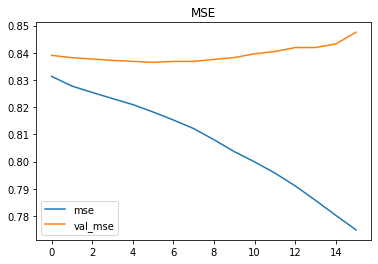

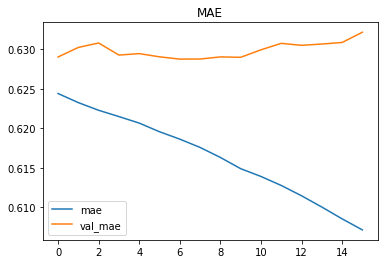

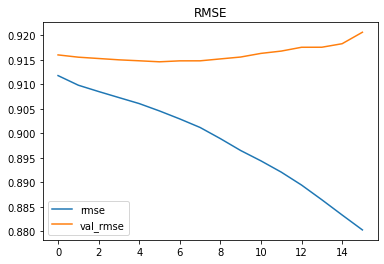

In [11]:
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(5, shuffle=True, random_state=42)
models = []
for index, (train_indices, valid_indices) in enumerate(kfold.split(train, investment_id)):
    X_train, X_val = train.iloc[train_indices], train.iloc[valid_indices]
    investment_id_train = investment_id[train_indices]
    y_train, y_val = y.iloc[train_indices], y.iloc[valid_indices]
    investment_id_val = investment_id[valid_indices]
    train_ds = make_dataset(X_train, investment_id_train, y_train)
    valid_ds = make_dataset(X_val, investment_id_val, y_val, mode="valid")
    model = get_model()
    checkpoint = keras.callbacks.ModelCheckpoint(f"model_{index}", save_best_only=True)
    early_stop = keras.callbacks.EarlyStopping(patience=10)
    history = model.fit(train_ds, epochs=50, validation_data=valid_ds, callbacks=[checkpoint, early_stop])
    model = keras.models.load_model(f"model_{index}")
    models.append(model)
    
    pearson_score = stats.pearsonr(model.predict(valid_ds).ravel(), y_val.values)[0]
    print('Pearson:', pearson_score)
    pd.DataFrame(history.history, columns=["mse", "val_mse"]).plot()
    plt.title("MSE")
    plt.show()
    pd.DataFrame(history.history, columns=["mae", "val_mae"]).plot()
    plt.title("MAE")
    plt.show()
    pd.DataFrame(history.history, columns=["rmse", "val_rmse"]).plot()
    plt.title("RMSE")
    plt.show()
    del investment_id_train
    del investment_id_val
    del X_train
    del X_val
    del y_train
    del y_val
    del train_ds
    del valid_ds
    gc.collect()
    break

In [12]:
def preprocess_test(investment_id, feature):
    return (investment_id, feature), 0
def make_test_dataset(feature, investment_id, batch_size=1024):
    ds = tf.data.Dataset.from_tensor_slices(((investment_id, feature)))
    ds = ds.map(preprocess_test)
    ds = ds.batch(batch_size).cache().prefetch(tf.data.experimental.AUTOTUNE)
    return ds
def inference(models, ds):
    y_preds = []
    for model in models:
        y_pred = model.predict(ds)
        y_preds.append(y_pred)
    return np.mean(y_preds, axis=0)